## Model specifications

|Model N | Specification | Parameters | Interpretation |
|--------|:------------- |:---------- | ---------------|
| 1 | log(y) ~ 1, $\epsilon \sim Poisson$| $\beta_{intercept}$ | No change in expression across space |
| 2 | log(y) ~ pc_1 + pc_2 + pc_3, $\epsilon \sim Poisson$ | $\beta_{intercept}$,  $\beta_{pc_1}$, $\beta_{pc_2}$, $\beta_{pc_3}$ |  Linear change in 3 directions
| 3 | log(y) ~ $\mu$ + $sector_1$ + $sector_2$, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, cutoff1, cutoff2, $\beta_{pc_1}$, $\beta_{pc_2}$ | 3 sectors, cut-off estimated
| 4 | log(y) ~  $\mu$ + sigmoid($sector_1$, cutoff1, k) + sigmoid($sector_2$, cutoff2, k) $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, $\beta_{pc_1}$, $\beta_{pc_2}$, cutoff1, cutoff2 | 3 sectors, cut-off estimated along projected axis

For all models, an alternative with a negative binomial distribution as the error distribution was also fitted.

In [20]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import glob
import os
import pickle as pkl
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from utils import *
from plotting_functions import *

%matplotlib inline

In [21]:
import scipy
scipy.__version__

'1.2.0'

In [14]:
def load_pkl(fn):
    if not os.path.exists(fn):
        return 0

    with open(fn, 'rb') as f:
        dat = pkl.load(f)
    
    return dat

def get_if_exists(d, key, return_length=False):
    if isinstance(d, dict):
        if return_length:
            return len(d[key])
        else:
            return d[key]
    else:
        return np.nan
    
def determine_res(d):
    if isinstance(d, dict):
        if not d['success'] and d['deoptim']['success']:
            d['deoptim']['bounds'] = d['bounds']
            d['deoptim']['nit'] = d['nit']
            return d['deoptim']
        else:
            return d
    else:
        return np.nan
    
def return_unique_id(x):
    dict_ = dict(zip(np.unique(x.values), np.arange(np.unique(x.values).shape[0])))
    return(dict_)


### Load data & fit results

In [18]:
def is_outlier(x, upper=5):
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    thresh = np.median(np.log(x))+upper*iqr
    outlier_idx = np.log(x) > thresh
    return outlier_idx
    
df['is_outlier'] = df.groupby(['subject_id', 'stain'])['rate'].apply(is_outlier)
df.groupby(['subject_id', 'stain']).is_outlier.sum().sum()/df.shape[0]

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


0.0007023809523809524

In [3]:
# load data
df = pd.read_pickle('./data_fwhm-0.3.pkl')
subjects = df.subject_id.unique()
stains = df.stain.unique()
models = [4,3,2,1]
distributions = ['poisson', 'nbinom']
output_dir = './models_ML/'

df = pd.merge(df, df.groupby(['subject_id']).slice_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'level_1': 'slice_mm', 'slice_mm': 'slice_sector_number'}), how='left')

combs = list(itertools.product(subjects, stains, models, distributions))
res_df = pd.DataFrame(combs, columns=['subject_id', 'stain', 'model', 'distribution'])
res_df['fn'] = 'sub-' + res_df['subject_id'].astype(str) + '_stain-' + res_df['stain'].astype(str) + '_model-' + res_df['model'].astype(str) + '_distribution-' + res_df['distribution'].astype(str) + '_fitresult.pkl'
res_df['res'] = res_df['fn'].apply(lambda x: load_pkl(output_dir + '/' + x))

# calculate BICs
res_df['n_pars'] = res_df['res'].apply(lambda x: get_if_exists(x, 'x', return_length=True))
res_df['n_obs'] = res_df['res'].apply(lambda x: get_if_exists(x, 'n_obs'))

# if polishing failed, revert to DEoptim results
res_df['res'] = res_df['res'].apply(lambda x: determine_res(x))
res_df['neg_ll'] = res_df['res'].apply(lambda x: get_if_exists(x, 'fun'))

res_df['bic'] = res_df['neg_ll'] + np.log(res_df['n_obs']) * res_df['n_pars']
res_df['model_dist'] = res_df['model'].astype(str) + res_df['distribution']
res_df['bic_minus_minbic'] = res_df.groupby(['subject_id', 'stain'])['bic'].apply(lambda x: x-x.min())
res_df['wbic'] = res_df.groupby(['subject_id', 'stain'])['bic_minus_minbic'].apply(lambda x: np.exp(-.5*x) / np.sum(np.exp(-.5*x)))

Any fits unfinished?

In [4]:
from IPython.display import display
# Were all fits completed successfully?
def any_nan(x):
    return np.sum(np.isnan(x) | np.isinf(x))

finished = res_df.pivot_table(index=['subject_id'], columns='stain', values='neg_ll', aggfunc=any_nan)
if np.sum(finished>0).sum() > 0:
    display(finished)

Any parameters close to the boundaries?

In [5]:
# for i, res in enumerate(res_df['res'].values):
#     if np.isclose(res['x'][0], res['bounds'][0][0], atol=.3) or np.isclose(res['x'][0], res['bounds'][0][1], atol=.3):
#         print('{} {} {} {}'.format(res_df.iloc[i]['model'], res_df.iloc[i]['stain'], res_df.iloc[i]['subject_id'], res_df.iloc[i]['distribution']))

def get_pars(df, model_n, error_dist='nbinom'):
    if model_n >= 1:
        columns = ['Intercept']
    if model_n >= 2:
        columns += ['beta_pc1', 'beta_pc2']
    if model_n == 2:
        columns += ['beta_slice']
    if model_n >= 3:
        columns += ['cutoff_1', 'cutoff_2', 'lambda1', 'lambda2']
    if model_n >= 4:
        columns += ['k']
    if error_dist=='nbinom':
        columns += ['alpha']
    
    par_df = df.loc[df.model==model_n,].set_index(['subject_id', 'stain']).res.apply(lambda x: get_if_exists(x, 'x'))
    par_df.dropna(inplace=True)
    par_df = pd.DataFrame(par_df.values.tolist(), index=par_df.index, columns=columns)
    return par_df

display(get_pars(res_df, 1).apply(lambda x: np.round([x.min(), x.max()], 2)))
display(get_pars(res_df, 2).apply(lambda x: np.round([x.min(), x.max()], 2)))
display(get_pars(res_df, 3).apply(lambda x: np.round([x.min(), x.max()], 2)))
display(get_pars(res_df, 4).apply(lambda x: np.round([x.min(), x.max()], 2)))

,Intercept,alpha
0,-0.93,0.0
1,4.83,1.0


,Intercept,beta_pc1,beta_pc2,beta_slice,alpha
0,-1.03,-1.30,-1.23,-0.92,0.0
1,4.82,0.58,0.85,0.51,1.0


,Intercept,beta_pc1,beta_pc2,cutoff_1,cutoff_2,lambda1,lambda2,alpha
0,-1.13,0.0,0.0,0.2,0.4,-1.00,-15.00,0.00
1,4.63,1.0,1.0,0.6,0.8,2.21,0.79,0.88


,Intercept,beta_pc1,beta_pc2,cutoff_1,cutoff_2,lambda1,lambda2,k,alpha
0,-5.76,0.0,0.0,0.2,0.4,-6.71,-15.0,0.0,0.00
1,7.26,1.0,1.0,0.6,0.8,12.12,6.6,1.0,0.87


In [6]:
model_n = 4
get_pars(res_df, model_n)[get_pars(res_df, model_n)['lambda2'] < -5]

# lambda2 = 15, so close to a boundary effect - but the difference between -15 and smaller is neglegible,
# due to the exponent (1e-15 ~ 0), so the quality of fit is unlikely to improve much beyond what it currently is

Intercept  beta_pc1      beta_pc2  cutoff_1  cutoff_2  \
subject_id stain                                                          
14069      MBP     3.594388       0.0  0.000000e+00       0.2  0.753761   
           MBP     3.603571       0.0  4.873278e-08       0.2  0.764116   

                   lambda1    lambda2         k     alpha  
subject_id stain                                           
14069      MBP   -0.826506 -14.990985  0.077514       NaN  
           MBP   -0.853326 -14.999983  0.088152  0.315279

In [7]:
# How smooth are the borders in model 4? Select only winning models
all_k = get_pars(res_df.loc[res_df.bic_minus_minbic==0], 4)['k']
all_k

subject_id  stain 
13095       GABRA3    0.435233
            MBP       0.079008
            PARV      0.963707
            SYN       0.256502
            TRANSF    1.000000
14037       SYN       1.000000
            TH        0.432332
            VGLUT1    0.672322
14051       FER       0.092733
            MBP       0.291241
            PARV      0.021300
            SYN       0.118921
            TRANSF    0.194681
14069       MBP       0.088152
            VGLUT1    0.023108
15035       GABRA3    0.089207
            PARV      0.150433
            SMI32     0.702616
            SYN       0.011073
            VGLUT1    0.067573
15055       GABRA3    0.642633
            MBP       0.814897
            PARV      0.415975
            SMI32     0.029462
            SYN       0.537294
            TH        0.999902
            VGLUT1    0.183294
Name: k, dtype: float64

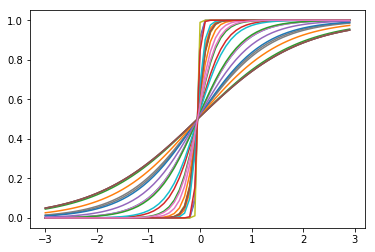

In [8]:
xs = np.arange(-3, 3, .1)
for k in all_k.values:
    plt.plot(xs, logistic(1, 0.5, 1/k, xs))
    
# Hard to qualify verbally, but this is a visualization of the smoothnesses

## Model comparison

In [9]:
# # lowest sum BIC per model
# to_include = res_df.loc[res_df.distribution=='nbinom']
# to_include['bic_minus_minbic'] = to_include.groupby(['subject_id', 'stain'])['bic'].apply(lambda x: x-x.min())
# to_include['wbic'] = to_include.groupby(['subject_id', 'stain'])['bic_minus_minbic'].apply(lambda x: np.exp(-.5*x) / np.sum(np.exp(-.5*x)))

# winners = to_include.loc[to_include.bic_minus_minbic == 0]
# winners_table = winners.pivot_table(index=['subject_id'], columns='stain', values='model', aggfunc=lambda x: x)
# winners_table[finished>0] = np.nan

# # overall winner across specimen
# winners_across_specimen = to_include.copy().groupby(['stain', 'model'])['bic'].apply(lambda x: x.sum())
# winners_across_specimen = winners_across_specimen.reset_index().groupby('stain').apply(lambda x: x['model'][np.argmin(x['bic'])])
# winners_across_specimen = pd.DataFrame(winners_across_specimen).T
# winners_across_specimen.index = ['Across specimen']
# winners_across_specimen.index.name = 'subject_id'
# winners_table = winners_table.append(winners_across_specimen)

# # Overall winners across stains
# winners_across_stains = to_include.copy().groupby(['subject_id', 'model'])['bic'].apply(lambda x: x.sum())
# winners_across_stains = winners_across_stains.reset_index().groupby('subject_id').apply(lambda x: x['model'][np.argmin(x['bic'])])
# winners_across_stains = pd.DataFrame(winners_across_stains)
# winners_across_stains.columns = ['overall']
# winners_table['Across stains'] = winners_across_stains['overall']

# # Overall winner across everything
# winner_overall = to_include.copy().groupby('model')['bic'].apply(lambda x: x.sum())
# winner_overall = winner_overall.index[np.argmin(winner_overall.values)]
# winners_table.loc['Across specimen', 'Across stains'] = winner_overall

# winners_table

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use

stain,CALR,FER,GABRA3,GAD6567,MBP,PARV,SERT,SMI32,SYN,TH,TRANSF,VGLUT1,Across stains
subject_id,,,,,,,,,,,,,
13095,2,2,4,2,4,4,3,2,4,2,4,2,4.0
14037,2,2,2,2,2,2,2,2,4,4,2,4,2.0
14051,2,4,2,2,4,4,2,2,4,2,4,2,2.0
14069,2,2,2,2,4,2,2,3,3,3,3,4,4.0
15033,2,2,2,2,2,2,2,2,2,2,2,2,2.0
15035,2,3,4,2,2,4,2,4,2,2,2,3,4.0
15055,2,2,4,2,4,4,2,4,4,4,2,4,4.0
Across specimen,2,4,2,2,4,4,2,2,4,2,4,4,2.0


In [12]:
# Highest mean weighted BIC
to_include = res_df.loc[res_df.distribution=='nbinom']
to_include['bic_minus_minbic'] = to_include.groupby(['subject_id', 'stain'])['bic'].apply(lambda x: x-x.min())
to_include['wbic'] = to_include.groupby(['subject_id', 'stain'])['bic_minus_minbic'].apply(lambda x: np.exp(-.5*x) / np.sum(np.exp(-.5*x)))

winners = to_include.loc[to_include.bic_minus_minbic == 0]
winners_table = winners.pivot_table(index=['subject_id'], columns='stain', values='model', aggfunc=lambda x: x)
winners_table[finished>0] = np.nan

# overall winner across specimen
winners_across_specimen = to_include.copy().groupby(['stain', 'model'])['wbic'].mean()
winners_across_specimen = winners_across_specimen.reset_index().groupby('stain').apply(lambda x: x['model'][np.argmax(x['wbic'])])
winners_across_specimen = pd.DataFrame(winners_across_specimen).T
winners_across_specimen.index = ['Across specimen']
winners_across_specimen.index.name = 'subject_id'
winners_table = winners_table.append(winners_across_specimen)

# Overall winners across stains
winners_across_stains = to_include.copy().groupby(['subject_id', 'model'])['wbic'].mean()
winners_across_stains = winners_across_stains.reset_index().groupby('subject_id').apply(lambda x: x['model'][np.argmax(x['wbic'])])
winners_across_stains = pd.DataFrame(winners_across_stains)
winners_across_stains.columns = ['overall']
winners_table['Across stains'] = winners_across_stains['overall']

# Overall winner across everything
winner_overall = to_include.copy().groupby('model')['wbic'].mean()
winner_overall = winner_overall.index[np.argmax(winner_overall.values)]
winners_table.loc['Across specimen', 'Across stains'] = winner_overall

winners_table

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


stain,CALR,FER,GABRA3,GAD6567,MBP,PARV,SERT,SMI32,SYN,TH,TRANSF,VGLUT1,Across stains
subject_id,,,,,,,,,,,,,
13095,2,2,4,2,4,4,3,2,4,2,4,2,2.0
14037,2,2,2,2,2,2,2,2,4,4,2,4,2.0
14051,2,4,2,2,4,4,2,2,4,2,4,2,2.0
14069,2,2,2,2,4,2,2,3,3,3,3,4,2.0
15033,2,2,2,2,2,2,2,2,2,2,2,2,2.0
15035,2,3,4,2,2,4,2,4,2,2,2,3,2.0
15055,2,2,4,2,4,4,2,4,4,4,2,4,4.0
Across specimen,2,2,2,2,4,4,2,2,4,2,2,2,2.0


In [11]:
# Distributions?
to_include = res_df
to_include['bic_minus_minbic'] = to_include.groupby(['subject_id', 'stain'])['bic'].apply(lambda x: x-x.min())
to_include['wbic'] = to_include.groupby(['subject_id', 'stain'])['bic_minus_minbic'].apply(lambda x: np.exp(-.5*x) / np.sum(np.exp(-.5*x)))

winners = to_include.loc[to_include.bic_minus_minbic == 0]
winners_table = winners.pivot_table(index=['subject_id'], columns='stain', values='distribution', aggfunc=lambda x: x)
winners_table[finished>0] = np.nan

winners_table

# hard to draw a conclusion from this...

stain,CALR,FER,GABRA3,GAD6567,MBP,PARV,SERT,SMI32,SYN,TH,TRANSF,VGLUT1
subject_id,,,,,,,,,,,,
13095,poisson,poisson,nbinom,poisson,nbinom,poisson,poisson,poisson,poisson,nbinom,poisson,poisson
14037,nbinom,poisson,nbinom,poisson,nbinom,poisson,poisson,nbinom,nbinom,poisson,nbinom,poisson
14051,nbinom,poisson,nbinom,poisson,nbinom,nbinom,poisson,nbinom,poisson,nbinom,poisson,poisson
14069,poisson,poisson,nbinom,poisson,nbinom,nbinom,poisson,nbinom,poisson,nbinom,nbinom,nbinom
15033,poisson,poisson,poisson,poisson,nbinom,nbinom,poisson,nbinom,poisson,poisson,nbinom,nbinom
15035,nbinom,poisson,poisson,poisson,nbinom,poisson,poisson,nbinom,poisson,nbinom,poisson,poisson
15055,nbinom,poisson,nbinom,nbinom,nbinom,nbinom,poisson,nbinom,poisson,poisson,nbinom,nbinom


# Illustrate fits

In [205]:
# Get model predictions
df_ppc = df.copy()
df_ppc['model_1_prediction'] = np.nan
df_ppc['model_2_prediction'] = np.nan
df_ppc['model_3_prediction'] = np.nan
df_ppc['model_4_prediction'] = np.nan
df_ppc['winning_model_prediction'] = np.nan
df_ppc['winning_model_no4_prediction'] = np.nan

for subject_id in df_ppc['subject_id'].unique():
    for stain in df_ppc['stain'].unique():
        idx_data = (df_ppc['subject_id'] == subject_id) & (df_ppc['stain'] == stain)
        
        for model in [1,2,3,4]:
            idx_res = (res_df['subject_id'] == subject_id) & (res_df['stain'] == stain) & (res_df['model'] == model) & (res_df['distribution'] == 'nbinom')
            pars = res_df.loc[idx_res, 'res'].apply(lambda x: get_if_exists(x, 'x')).iloc[0]
            df_ppc.loc[idx_data, 'model_'+str(model)+'_prediction'] = get_ev(pars, model, 
                                                                             df_ppc.loc[idx_data, 'pc1_mm_norm'],
                                                                             df_ppc.loc[idx_data, 'pc2_mm_norm'],
                                                                             df_ppc.loc[idx_data, 'slice_mm_norm'],
                                                                             return_projection_axis=False)
            if model > 1:
                df_ppc.loc[idx_data, 'model_'+str(model)+'_pa'] = get_ev(pars, model, 
                                                                             df_ppc.loc[idx_data, 'pc1_mm_norm'],
                                                                             df_ppc.loc[idx_data, 'pc2_mm_norm'],
                                                                             df_ppc.loc[idx_data, 'slice_mm_norm'],
                                                                             return_projection_axis=True)
        
        # get winning model
        winning_model = winners.loc[(winners['bic_minus_minbic']==0) & (winners['subject_id']==subject_id) & (winners['stain']==stain), 'model_dist'].iloc[0]
        idx_res = (res_df['subject_id'] == subject_id) & (res_df['stain'] == stain) & (res_df['model_dist'] == winning_model)
        winning_pars = res_df.loc[idx_res, 'res'].apply(lambda x: get_if_exists(x, 'x')).iloc[0]
        df_ppc.loc[idx_data, 'winning_model_prediction'] = get_ev(winning_pars, float(winning_model[0]), 
                                                                  df_ppc.loc[idx_data, 'pc1_mm_norm'],
                                                                  df_ppc.loc[idx_data, 'pc2_mm_norm'],
                                                                  df_ppc.loc[idx_data, 'slice_mm_norm'],
                                                                  return_projection_axis=False)

/home/stevenm/git_projects/histochemical_mri_stn/notebooks/utils.py:7: RuntimeWarning: overflow encountered in exp
  return L/(1+np.exp(-k*(t_-x0)))


In [224]:
### Plot per subject/stain separately

KeyboardInterrupt: 

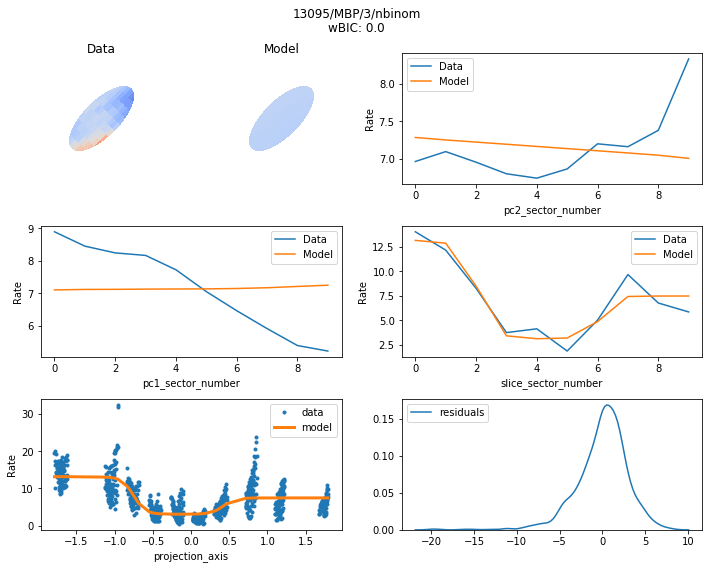

In [20]:
from matplotlib.backends.backend_pdf import PdfPages
if not os.path.exists('./fits'):
    os.makedirs('fits')

for subject_id in subjects:
    for stain in stains:
        fn = 'fits/sub-{}_stain-{}_fits.pdf'.format(subject_id, stain)
        pdf = PdfPages(fn)
        
        for distribution in distributions:
            for model_n in [1,2,3,4]:
                idx = (res_df.subject_id == subject_id) & (res_df.model == model_n) & (res_df.stain == stain) & (res_df.distribution == distribution)
                data_idx = (df.subject_id == subject_id) & (df.stain == stain)
                fit_result = res_df.loc[idx, 'res'].iloc[0]
                
                data_ppc = df.loc[data_idx].copy()
                data_ppc['y_predicted'] = get_ev(fit_result['x'], model_n, data_ppc['pc1_mm_norm'].values, data_ppc['pc2_mm_norm'].values, data_ppc['slice_mm_norm'].values)

                if model_n > 1:
                    data_ppc['projection_axis'] = get_ev(fit_result['x'], model_n, data_ppc['pc1_mm_norm'].values, data_ppc['pc2_mm_norm'].values, data_ppc['slice_mm_norm'].values, return_projection_axis=True)

                data_ppc['residuals'] = data_ppc['y_predicted']-data_ppc['rate']
                wBIC = np.round(res_df.loc[idx, 'wbic'].iloc[0],3)
                
                f = plot_single_pc(data_ppc, type='_sector_number')
                f.tight_layout()
                f.subplots_adjust(top=.90)
                f.suptitle('{}/{}/{}/{}\nwBIC: {}'.format(subject_id, stain, model_n, distribution, wBIC))
                
                f.set_size_inches(10, 8)
                pdf.savefig(f)
        pdf.close()

In [126]:
# single subject/stain
model_n = 4
error_dist = 'nbinom'
subject_id = 15035
stain = 'FER'
idx = (res_df.subject_id == subject_id) & (res_df.model == model_n) & (res_df.stain == stain) & (res_df.distribution == error_dist)
data_idx = (df.subject_id == subject_id) & (df.stain == stain)

fit_result = res_df.loc[idx, 'res'].iloc[0]
print(np.round(fit_result['x'],2))
print(np.round(fit_result['bounds'], 2))

data_ppc = df.loc[data_idx].copy()
data_ppc['y_predicted'] = get_ev(fit_result['x'], model_n, data_ppc['pc1_mm_norm'].values, data_ppc['pc2_mm_norm'].values, data_ppc['slice_mm_norm'].values)

if model_n > 1:
    data_ppc['projection_axis'] = get_ev(fit_result['x'], model_n, data_ppc['pc1_mm_norm'].values, data_ppc['pc2_mm_norm'].values, data_ppc['slice_mm_norm'].values, return_projection_axis=True)
    
data_ppc['residuals'] = data_ppc['y_predicted']-data_ppc['rate']

[ 2.96  0.    0.    0.33  0.53 -0.44 -0.14  0.02  0.  ]
[[-8.   13.38]
 [ 0.    1.  ]
 [ 0.    1.  ]
 [ 0.2   0.6 ]
 [ 0.4   0.8 ]
 [-8.   13.38]
 [-8.   13.38]
 [ 0.    1.  ]
 [ 0.    1.  ]]


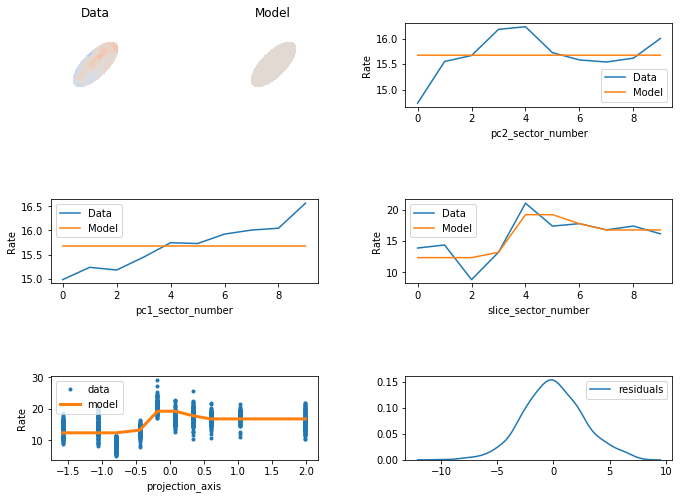

In [23]:
f = plot_single_pc(data_ppc, type='_sector_number')
f.tight_layout()
f.set_size_inches(10, 8)

In [225]:
# across participants
def plot_single_pc_ms(df, type='_mm_norm', pred_column=['y_predicted'], projection_axis_name=None):
    """
    Plots the STN, collapsing over a dimension
    """
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import matplotlib.patheffects as pe
    gs = gridspec.GridSpec(3, 4)
    ax_stn_data = plt.subplot(gs[0,0])
    ax_stn_model = plt.subplot(gs[0,1])
    
    ax_graph1 = plt.subplot(gs[1,0:2])
    ax_graph2 = plt.subplot(gs[0,2:4])
    ax_graph3 = plt.subplot(gs[1,2:4])
    
    proj_axis = plt.subplot(gs[2,0:2])
    residuals_ax = plt.subplot(gs[2,2:4])
    
    vmin, vmax = np.nanpercentile(df['rate'], [5, 95])

    visualize_stn_model(df, dependent_var='rate', ax=ax_stn_data, vmin=vmin, vmax=vmax)
    visualize_stn_model(df, dependent_var=pred_column, ax=ax_stn_model, vmin=vmin, vmax=vmax)
    
    subs = df.subject_id.unique()
    cmap = plt.get_cmap('Set2')
    colors = [cmap(i) for i in np.linspace(0, 1, subs.shape[0])]
    
    # data...
    for sub, color in zip(subs, colors):
        df_sub = df.loc[df.subject_id==sub]
        plot_intensity_across_axis(df_sub, dependent_var='rate', ax=ax_graph1, x_axis='pc1'+type, 
                                   label=sub, linestyle="", marker=".", color=color)
        plot_intensity_across_axis(df_sub, dependent_var='rate', ax=ax_graph2, x_axis='pc2'+type, 
                                   label=sub, linestyle="", marker=".", color=color)
        plot_intensity_across_axis(df_sub, dependent_var='rate', ax=ax_graph3, x_axis='slice'+type, 
                                   label=sub, linestyle="", marker=".", color=color)

        if projection_axis_name is not None and projection_axis_name in df_sub.columns:
            df_sub = df_sub.sort_values(projection_axis_name)
            proj_axis.plot(df_sub[projection_axis_name], df_sub["rate"], '.', label='data', color=color)
            proj_axis.set_xlabel('projection_axis')
            proj_axis.set_ylabel('Rate')

    # predictions...
    for sub, color in zip(subs, colors):
        df_sub = df.loc[df.subject_id==sub]
        plot_intensity_across_axis(df_sub, dependent_var=pred_column, ax=ax_graph1, x_axis='pc1'+type, label=None, 
                                   color=color, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
        plot_intensity_across_axis(df_sub, dependent_var=pred_column, ax=ax_graph2, x_axis='pc2'+type, label=None, 
                                   color=color, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
        plot_intensity_across_axis(df_sub, dependent_var=pred_column, ax=ax_graph3, x_axis='slice'+type, label=None,
                                   color=color, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

        if projection_axis_name is not None and projection_axis_name in df_sub.columns:
            df_sub = df_sub.sort_values(projection_axis_name)
            proj_axis.plot(df_sub[projection_axis_name], df_sub[pred_column], linewidth=2, label='model', 
                           color=color, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
            proj_axis.set_xlabel('projection_axis')
            proj_axis.set_ylabel('Rate')

        sns.kdeplot(df_sub[pred_column] - df_sub['rate'], ax=residuals_ax, color=color)

    ax_stn_data.set_title('Data')
    ax_stn_model.set_title('Model')
#     ax_graph1.legend()
#     ax_graph2.legend()
#     ax_graph3.legend()
    
    return plt.gcf()

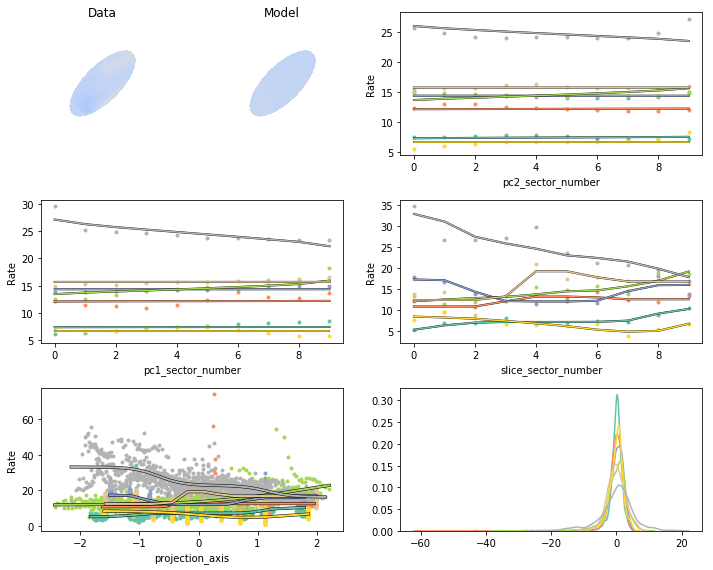

In [204]:
for stain in stains:
    fn = 'fits/stain-{}_fits.pdf'.format(stain)
    pdf = PdfPages(fn)

    for model in [1,2,3,4]:

        f = plot_single_pc_ms(df_ppc.loc[df_ppc.stain=='FER'], 
                              type='_sector_number', 
                              pred_column='model_' + str(model) + '_prediction',
                              projection_axis_name='model_' + str(model) + '_pa')
        f.tight_layout()
        f.set_size_inches(10, 8)
        pdf.savefig(f)
    pdf.close()        

### Plot overall STN, data versus model

In [226]:
# Generate string sector labels for plotting
df_ppc['slice_5'] = np.floor(df['slice_sector_number']/2)
df_ppc['pc1_sector_labels'] = 'vmd_' + df_ppc['pc1_sector_number'].astype(int).astype(str)
df_ppc['pc2_sector_labels'] = 'mml_' + df_ppc['pc2_sector_number'].astype(int).astype(str)
df_ppc['slice_sector_labels'] = 'pma_' + df_ppc['slice_5'].astype(int).astype(str)

In [227]:
# Set all intensity expressions on a common scale for plotting
for col in ['model_1_prediction', 'model_2_prediction', 'model_3_prediction', 'model_4_prediction', 'winning_model_prediction', 'winning_model_no4_prediction']:
    df_ppc[col + '_norm'] = df_ppc[col] - df_ppc.groupby(['subject_id', 'stain'])['rate'].transform(np.mean)
    df_ppc[col + '_norm'] = df_ppc[col + '_norm'] / df_ppc.groupby(['subject_id', 'stain'])['rate'].transform(np.std)
    
df_ppc['rate_norm'] = df_ppc.groupby(['subject_id', 'stain'])['rate'].apply(lambda x: (x-x.mean())/x.std())

In [228]:
n_sectors_per_axis = 10
n_slices = 5

In [19]:
vminmax = df_ppc.groupby('stain').rate_norm.apply(lambda x: np.percentile(x, [5, 95])).to_dict()
plot_stns(df_ppc, y_type='rate_norm', vminmax = vminmax)
fn = '/home/stevenm/data/post_mortem/visualize_stains_v2/glms/data.pdf'
pdf = PdfPages(fn)
plt.gcf().savefig(pdf,  format='pdf')
pdf.close()

plot_stns(df_ppc, y_type='model_2_prediction_norm', vminmax = vminmax)
fn = '/home/stevenm/data/post_mortem/visualize_stains_v2/glms/model.pdf'
pdf = PdfPages(fn)
plt.gcf().savefig(pdf,  format='pdf')
pdf.close()

NameError: name 'df_ppc' is not defined

##### winners (highest mean wBIC)

2 4 4

2 4 2

2 2 2

2 2 2


##### winners (lowest sum BIC)
2 4 4

4 4 2

2 2 4

2 2 4

0 4 0 3 0 2 0 1 0 0 1 4 1 3 1 2 1 1 1 0 2 4 2 3 2 2 2 1 2 0 3 4 3 3 3 2 3 1 3 0 0 9 0 8 0 7 0 6 0 5 1 9 1 8 1 7 1 6 1 5 2 9 2 8 2 7 2 6 2 5 3 9 3 8 3 7 3 6 3 5 0 14 0 13 0 12 0 11 0 10 1 14 1 13 1 12 1 11 1 10 2 14 2 13 2 12 2 11 2 10 3 14 3 13 3 12 3 11 3 10 0 4 0 3 0 2 0 1 0 0 1 4 1 3 1 2 1 1 1 0 2 4 2 3 2 2 2 1 2 0 3 4 3 3 3 2 3 1 3 0 0 9 0 8 0 7 0 6 0 5 1 9 1 8 1 7 1 6 1 5 2 9 2 8 2 7 2 6 2 5 3 9 3 8 3 7 3 6 3 5 0 14 0 13 0 12 0 11 0 10 1 14 1 13 1 12 1 11 1 10 2 14 2 13 2 12 2 11 2 10 3 14 3 13 3 12 3 11 3 10 

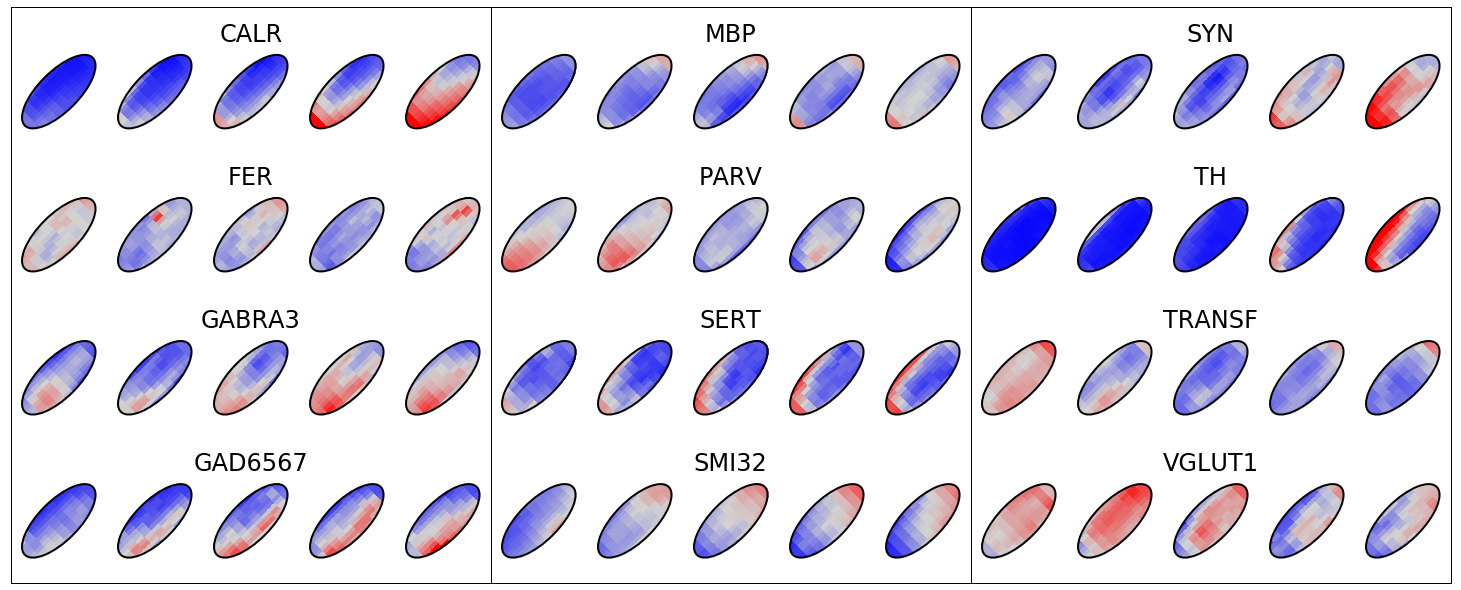

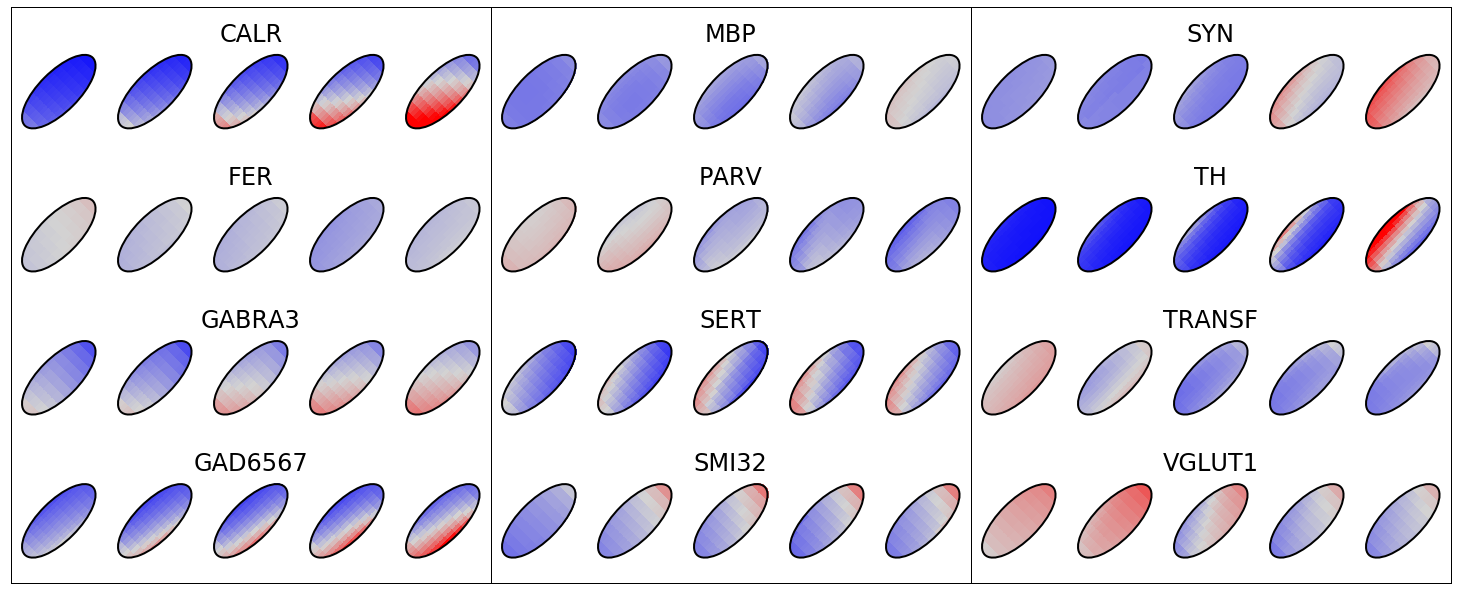

In [213]:
plot_stns(df_ppc, y_type='rate_norm', vminmax = vminmax)
plot_stns(df_ppc, y_type='winning_model_prediction_norm', vminmax = vminmax)